# Laptop specifications scrapper
Scrap comparez-malin.com for laptop specification

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import qgrid
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from laptop_scoring import scrapping
from laptop_scoring.processing import get_min_price, process_and_clean
from laptop_scoring.utils import scale, ease, display_laptop, print_score, row2html, draw_rank_page

sns.set_style("darkgrid")

## Get all specs needed

In [2]:
overwrite = False  # Wether to redownload everything or read stored dataframes

# Get links to each laptop page in a  dataframe
df_urls = scrapping.get_laptops_urls(overwrite=False)
df_urls["prix_min"] = get_min_price(df_urls)

# Get specs for all laptops
df = scrapping.get_all_laptops_specs(df_urls, overwrite=overwrite)
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace(".", "").str.replace("(", "").str.replace(")", "")

# Get CPU and GPU benchmarks
df_cpu = scrapping.get_cpu_dataframe(df["processeur"].fillna("").unique(), overwrite=overwrite)
df = df.reset_index().merge(df_cpu, on="processeur", how="left").set_index("index")

df_gpu = scrapping.get_gpu_dataframe(df["puce_graphique_dédiée"].fillna("").unique(), overwrite=overwrite)
df = df.reset_index().merge(df_gpu, on="puce_graphique_dédiée", how="left").set_index("index")

# Processing and cleaning
df = process_and_clean(df)
df_ori = df.copy()

Reading dataframe from data/get_laptops_urls.csv
Reading dataframe from data/get_all_laptops_specs.csv
Reading dataframe from data/get_cpu_dataframe.csv
Reading dataframe from data/get_gpu_dataframe.csv


In [3]:
scrapping.save_images(df_urls)

100%|██████████| 2845/2845 [00:00<00:00, 5201.18it/s]


## Scoring

In [4]:
df = df_ori.copy()

# Wether to use official price (might not be available) or current price
#prix = "prix_public"
prix = "prix_min"
if prix in ["prix", "prix_min"]:
    # Remove laptops with no current price (often because unavailable)
    df = df[~np.isnan(df["prix"])]

# Adjust the coefficients to your liking !
# List of tuples: (col_name, method, do_scale)
scoring_methods = [
    (prix, lambda x: -x * 4, True),
    ("single_core_benchmark", lambda x: x * 0.6, True),
    ("coeurs", lambda x: x * 0.5, True),
    ("mémoire_ram", lambda x: x * 0.4, True),
    ("gpu_benchmark", lambda x: ease(x, method="log", asymetric=True) * 1.5, True),
    ("min_freq", lambda x: x * 0.2, True),
    ("max_freq", lambda x: x * 0.2, True),
    ("pdt_max", lambda x: x * -0.15, True),
    ("hdd_speed", lambda x: (x==7200) * 0.1, False),
    ("sshd", lambda x: x * 0.2, False),
    ("ssd_size", lambda x: ((x>0) + ease(x))/2 * 0.4, True),
    ("poids", lambda x: x * -0.5, True),
    ("height", lambda x: -x * 0.7, True),
    ("taille", lambda x: (x>15.6 or x<13.3) * -3 + (x<14) * -2, False),
    ("screen_to_body", lambda x: x * 0.5, True),
    ("res_width", lambda x: (x<1920) * -2 + (x>1920) * 0.3 , False),
    ("composition",
     lambda x: (
            (("Aluminium" in x) or ("Métal" in x)) * 0.4
           + ("Plastique" in x) * -0.4
        ) , False),
    ("type_c",
     lambda x: (
            ("Gen 1" in x) * 0.1
          + ("Gen 2" in x) * 0.2
          + ("Thunderbolt" in x) * 0.2
          + ("Charging" in x) * 0.2
        ), False),
    ("marque", lambda x: (x=="Acer") * -0 + (x=="MSI") * -0 + (x=="Dell") * 1, False),  # Acer is not good quality and MSI are ugly
    ("url", lambda x: ("rog" in x) * -0, False)  # Asus ROG are ugly
]

df_score = pd.DataFrame(index=df.index, columns=["score"])


# Generic methods that take one column as input
# and output its associated score
for (col_name, method, do_scale) in tqdm(scoring_methods):
    col = df[col_name]
    if do_scale:
        col = scale(col)
    df_score[col_name] = col.apply(method)

# Compute total score
df_score = df_score.fillna(0)
df_score["total"] = df_score.drop(["score"], axis=1).sum(axis=1)
max_score = df_score["total"].max()
min_score = df_score["total"].min()
df_score["score"] = (df_score["total"] - min_score)/(max_score - min_score)
df["score"] = df_score["score"]
df = df.sort_values(by="score", ascending=False)
df_score = df_score.loc[df.index]

100%|██████████| 20/20 [00:00<00:00, 178.29it/s]


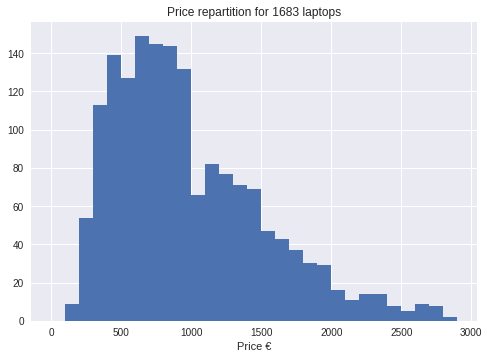

In [5]:
plt.hist(df["prix"].as_matrix(), bins=[i*100 for i in range(30)])
plt.title("Price repartition for {} laptops".format(df.shape[0]))
plt.xlabel("Price €")
plt.show()

## Filtering

In [6]:
# Keep only computers that fit your needs
#df = df[df["gpu_benchmark"]>500]  # At least a GTX 920M
df = df[df["gpu_benchmark"]>1500]  # At least a GTX 950M
df = df[df["cpu_benchmark"]>3000]  # At least a i5-4210U
df = df[(df["taille"]>=13.3) & (df["taille"]<=15.6)]
df = df[df["res_width"]>=1920]
#df = df[df["marque"]!="MSI"]
#df = df[df["url"].apply(lambda x: "rog" not in x)]
#df = df[df["marque"]=="Asus"]
#df = df[df["url"].apply(lambda x: "rog" not in x)]
#df = df[df["référence"].apply(lambda x: "UX" in x)]

## Display results

In [7]:
#qgrid.set_defaults(grid_options={'forceFitColumns': False})#, 'defaultColumnWidth': 200})
cols_to_show = ("url score marque référence processeur puce_graphique_dédiée mémoire_ram ssd_size taille res_width " + prix).split()
#height single_core_benchmark coeurs cpu_benchmark gpu_benchmark min_freq max_freq pdt_max hdd_speed sshd prix_public
qgrid.show_grid(df[cols_to_show])
#df_score.head()

## Top results

In [8]:
draw_rank_page(df, start=0, offline=False)

Page 1.
